# Importing Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Import Dataset

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/Datasets/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Datasets/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Datasets/sample_submission.csv')

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


# Dropping Irrelvent columns

In [7]:
cols_to_drop = ['PassengerId', 'Name']

# Drop from both train and test
train_data = train_data.drop(columns=cols_to_drop, errors='ignore')
test_data = test_data.drop(columns=cols_to_drop, errors='ignore')

Train Null Counts:
 HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

Test Null Counts:
 HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
dtype: int64


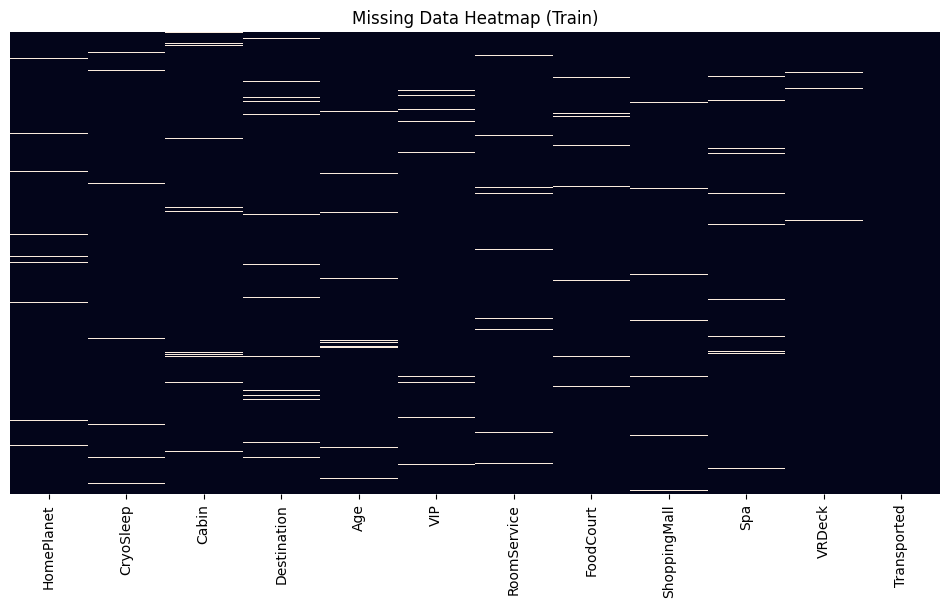

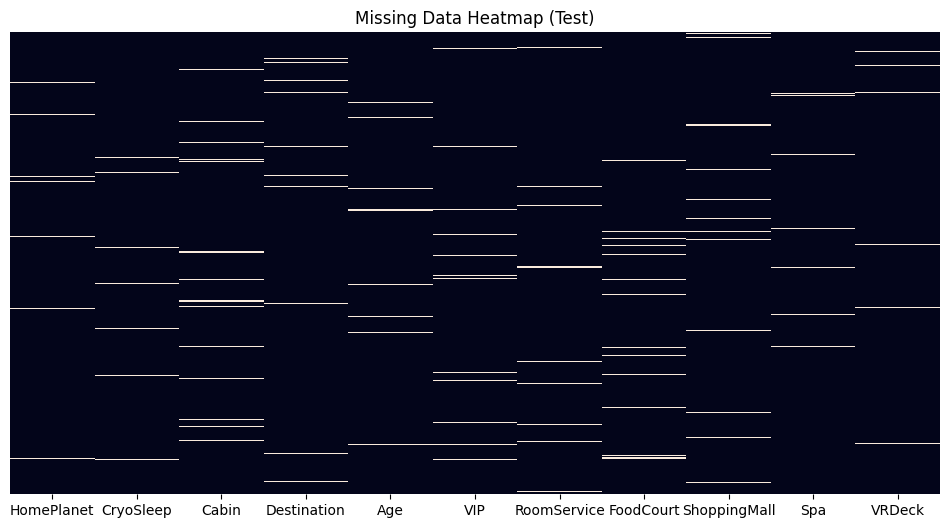

In [8]:
# Null analysis
print("Train Null Counts:\n", train_data.isnull().sum())
print("\nTest Null Counts:\n", test_data.isnull().sum())

# Plot missing values for train and test
plt.figure(figsize=(12,6))
sns.heatmap(train_data.isnull(), cbar=False, yticklabels=False)
plt.title('Missing Data Heatmap (Train)')
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(test_data.isnull(), cbar=False, yticklabels=False)
plt.title('Missing Data Heatmap (Test)')
plt.show()

# Imputing NULL Values using KNN

In [9]:
def encode_and_impute(train_data, test_data, cols_to_impute, cat_cols, n_neighbors=5):
    # --- Encode Categorical Columns ---
    train_copy = train_data.copy()
    test_copy = test_data.copy()
    encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        # Fit on non-null values from train only
        train_copy[col] = train_copy[col].astype(str)
        mask_train = train_data[col].notnull()
        le.fit(train_copy.loc[mask_train, col])
        encoders[col] = le
        # Use -1 for NaNs
        train_copy.loc[~mask_train, col] = -1
        # Transform (safe because -1 is not in training data)
        train_copy.loc[mask_train, col] = le.transform(train_copy.loc[mask_train, col])
        train_copy[col] = train_copy[col].astype(int)
        train_copy.loc[~mask_train, col] = -1  # make sure -1 for missing

        # For test data
        test_copy[col] = test_copy[col].astype(str)
        mask_test = test_data[col].notnull()
        test_copy.loc[~mask_test, col] = -1
        # Only transform values seen in train, unknowns to -1
        # Map values not in le.classes_ to -1
        test_copy.loc[mask_test, col] = test_copy.loc[mask_test, col].map(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
        test_copy[col] = test_copy[col].astype(int)
        test_copy.loc[~mask_test, col] = -1

    # --- Ensure numeric ---
    for col in cols_to_impute:
        train_copy[col] = pd.to_numeric(train_copy[col], errors='coerce')
        test_copy[col] = pd.to_numeric(test_copy[col], errors='coerce')

    # --- Fit KNN Imputer on train, transform both ---
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputer.fit(train_copy[cols_to_impute])
    train_imputed = imputer.transform(train_copy[cols_to_impute])
    test_imputed = imputer.transform(test_copy[cols_to_impute])

    train_imputed_df = pd.DataFrame(train_imputed, columns=cols_to_impute, index=train_copy.index)
    test_imputed_df = pd.DataFrame(test_imputed, columns=cols_to_impute, index=test_copy.index)

    # --- Decode categorical columns ---
    for col in cat_cols:
        le = encoders[col]
        train_imputed_df[col] = train_imputed_df[col].round().astype(int)
        test_imputed_df[col] = test_imputed_df[col].round().astype(int)
        # Clip negative values to 0 to avoid decode errors
        train_imputed_df[col] = np.where(train_imputed_df[col] < 0, 0, train_imputed_df[col])
        test_imputed_df[col] = np.where(test_imputed_df[col] < 0, 0, test_imputed_df[col])
        train_imputed_df[col] = le.inverse_transform(train_imputed_df[col])
        test_imputed_df[col] = le.inverse_transform(test_imputed_df[col])

    # --- Assign back to main dataframes ---
    for col in cols_to_impute:
        train_data[col] = train_imputed_df[col]
        test_data[col] = test_imputed_df[col]

    return train_data, test_data

# Usage
cols_to_impute = [
    'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
    'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'
]
cat_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

train_data, test_data = encode_and_impute(train_data, test_data, cols_to_impute, cat_cols, n_neighbors=5)

# Check
print(train_data[cols_to_impute].isnull().sum())
print(test_data[cols_to_impute].isnull().sum())

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


# EDA

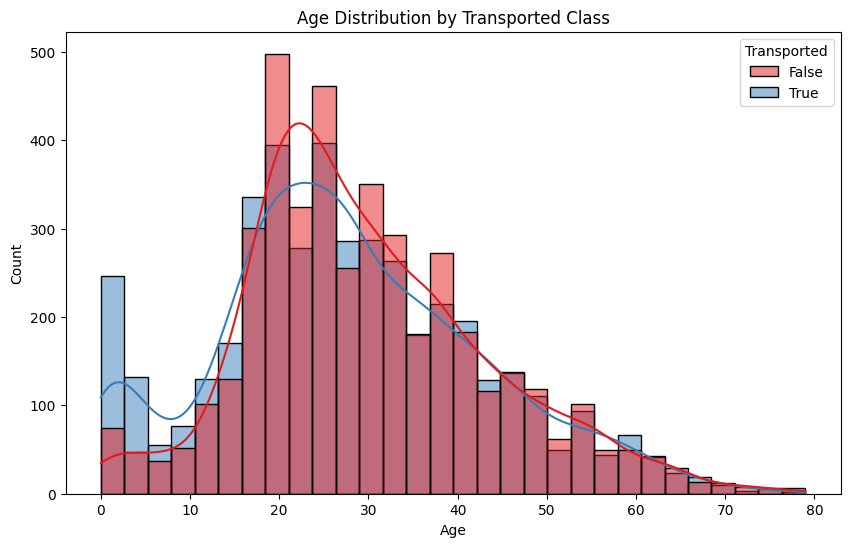

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=train_data,
    x='Age',
    hue='Transported',
    bins=30,
    kde=True,
    palette='Set1',
    alpha=0.5,
    legend=True    # This is default, but explicitly set for clarity
)
plt.title('Age Distribution by Transported Class')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

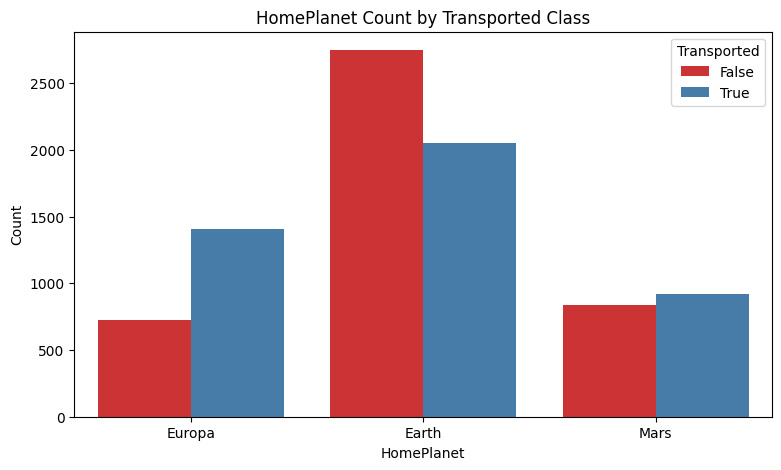

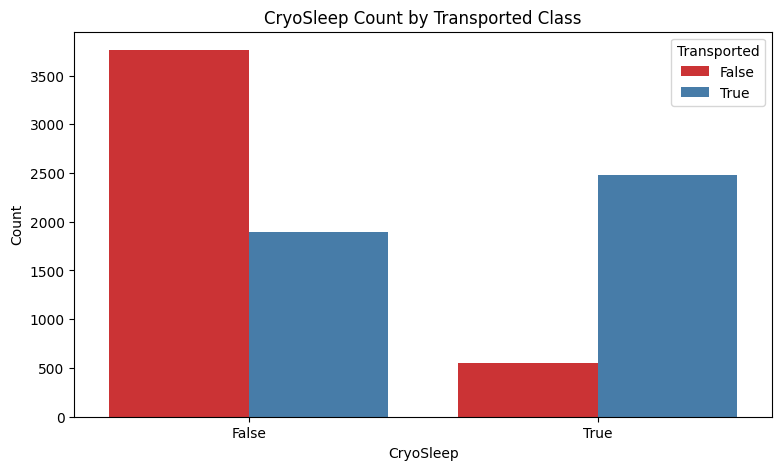

In [11]:
cat_cols = ['HomePlanet', 'CryoSleep']

for col in cat_cols:
    plt.figure(figsize=(9, 5))
    sns.countplot(
        x=col,
        hue='Transported',
        data=train_data,
        palette='Set1'
    )
    plt.title(f'{col} Count by Transported Class')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Transported')
    plt.show()


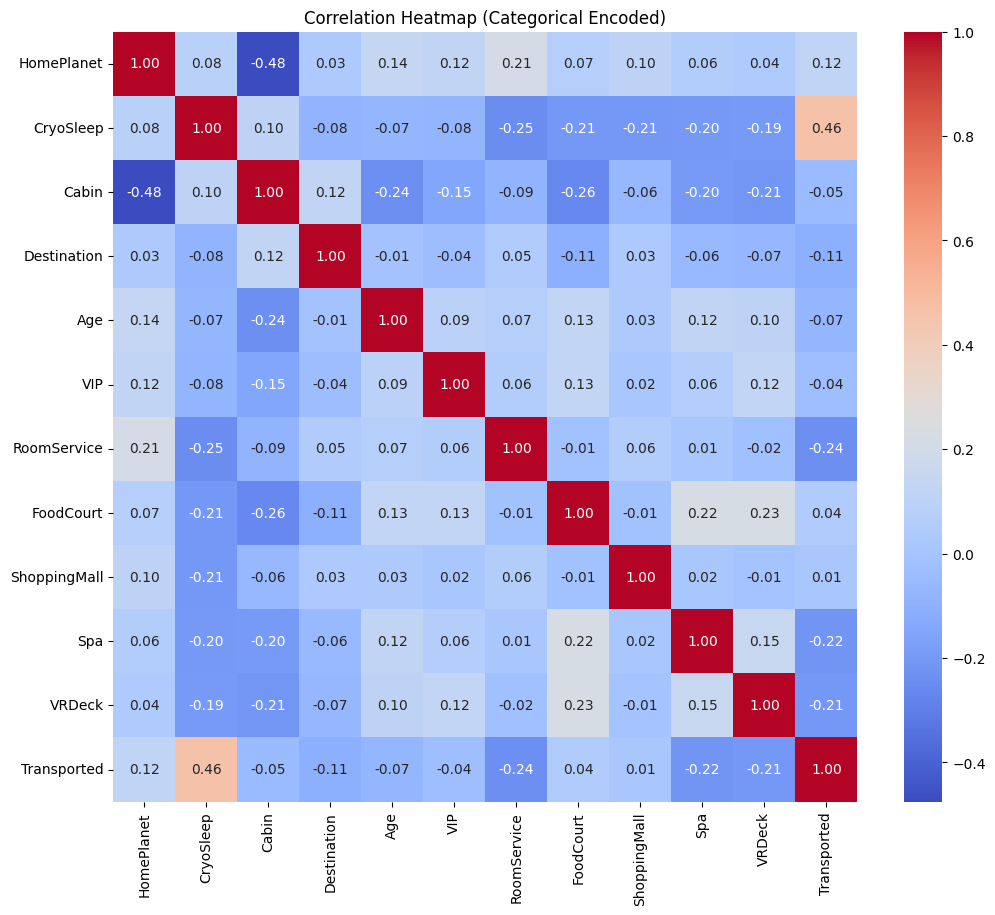

In [12]:
# Identify categorical columns
cat_cols = train_data.select_dtypes(include=['object', 'bool']).columns

# Create a copy to avoid changing your main data
train_num = train_data.copy()

# Apply LabelEncoder to each categorical column
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    train_num[col] = train_num[col].astype(str)  # Convert NaN to 'nan' string
    train_num[col] = le.fit_transform(train_num[col])
    le_dict[col] = le


plt.figure(figsize=(12,10))
corr = train_num.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Categorical Encoded)')
plt.show()

# Lable Encoding

In [13]:
# Copy to avoid changing original data
train_encoded = train_data.copy()
test_encoded = test_data.copy()

# Identify categorical columns (object or bool, EXCLUDING target if present)
cat_cols = train_encoded.select_dtypes(include=['object', 'bool']).columns
cat_cols = [col for col in cat_cols if col != 'Transported']

# Dictionary to save LabelEncoders
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    # Fit on train
    train_encoded[col] = train_encoded[col].astype(str)
    le.fit(train_encoded[col])
    le_dict[col] = le
    # Transform train
    train_encoded[col] = le.transform(train_encoded[col])
    # For test: handle unseen categories with '<unk>'
    test_encoded[col] = test_encoded[col].astype(str)
    # Add '<unk>' to encoder classes if necessary
    if '<unk>' not in le.classes_:
        le.classes_ = np.append(le.classes_, '<unk>')
    test_encoded[col] = test_encoded[col].map(lambda s: s if s in le.classes_ else '<unk>')
    test_encoded[col] = le.transform(test_encoded[col])

# Feature Selection

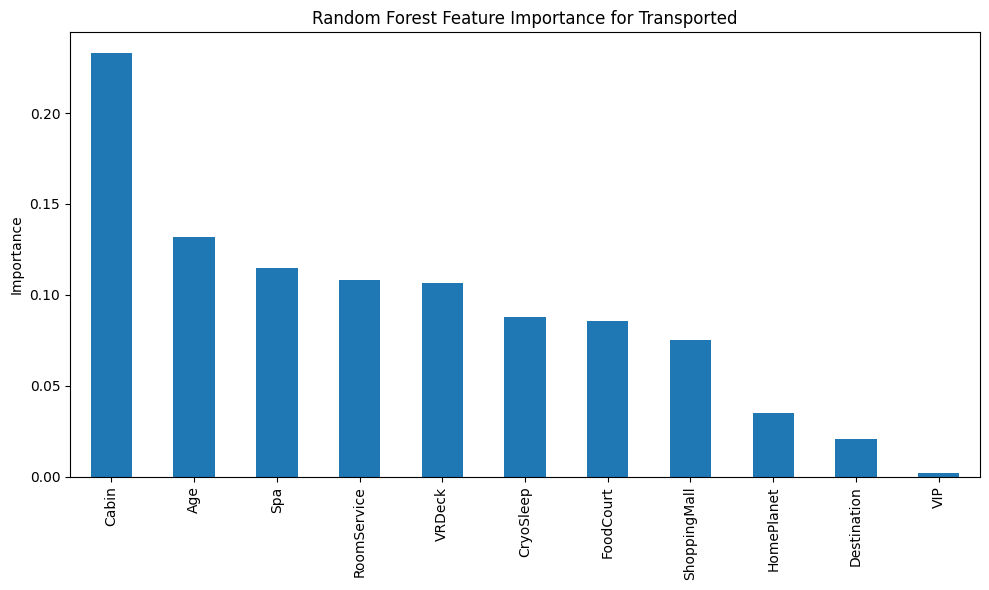

In [14]:
X = train_encoded.drop('Transported', axis=1)
y = train_encoded['Transported']

# Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
importances.plot(kind='bar')
plt.title('Random Forest Feature Importance for Transported')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


# Extrcting Top Features

In [15]:
top_features = importances.head(6).index.tolist()
X_train = train_encoded[top_features]
X_test = test_encoded[top_features]
y_train = train_encoded['Transported']

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Defination For Neural Network

In [17]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_ckpt = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, min_lr=1e-6)

# Training Neural Network

In [19]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stop, model_ckpt, reduce_lr]
)

Epoch 1/30


218/218 - 5s - 21ms/step - accuracy: 0.6872 - loss: 0.6146 - val_accuracy: 0.7878 - val_loss: 0.5166 - learning_rate: 1.0000e-03
Epoch 2/30


218/218 - 2s - 11ms/step - accuracy: 0.7322 - loss: 0.5451 - val_accuracy: 0.7786 - val_loss: 0.4657 - learning_rate: 1.0000e-03
Epoch 3/30


218/218 - 1s - 6ms/step - accuracy: 0.7442 - loss: 0.5286 - val_accuracy: 0.7872 - val_loss: 0.4457 - learning_rate: 1.0000e-03
Epoch 4/30


218/218 - 2s - 10ms/step - accuracy: 0.7514 - loss: 0.5212 - val_accuracy: 0.7838 - val_loss: 0.4438 - learning_rate: 1.0000e-03
Epoch 5/30
218/218 - 1s - 4ms/step - accuracy: 0.7601 - loss: 0.5111 - val_accuracy: 0.7884 - val_loss: 0.4448 - learning_rate: 1.0000e-03
Epoch 6/30


218/218 - 1s - 4ms/step - accuracy: 0.7660 - loss: 0.5086 - val_accuracy: 0.7895 - val_loss: 0.4434 - learning_rate: 1.0000e-03
Epoch 7/30
218/218 - 1s - 4ms/step - accuracy: 0.7597 - loss: 0.5097 - val_accuracy: 0.7884 - val_loss: 0.4461 - learning_rate: 1.0000e-03
Epoch 8/30


218/218 - 1s - 4ms/step - accuracy: 0.7678 - loss: 0.5015 - val_accuracy: 0.7884 - val_loss: 0.4424 - learning_rate: 1.0000e-03
Epoch 9/30


218/218 - 1s - 4ms/step - accuracy: 0.7657 - loss: 0.5011 - val_accuracy: 0.7895 - val_loss: 0.4397 - learning_rate: 1.0000e-03
Epoch 10/30
218/218 - 1s - 6ms/step - accuracy: 0.7761 - loss: 0.4974 - val_accuracy: 0.7918 - val_loss: 0.4431 - learning_rate: 1.0000e-03
Epoch 11/30


218/218 - 1s - 6ms/step - accuracy: 0.7715 - loss: 0.4934 - val_accuracy: 0.7930 - val_loss: 0.4373 - learning_rate: 1.0000e-03
Epoch 12/30
218/218 - 1s - 5ms/step - accuracy: 0.7718 - loss: 0.4968 - val_accuracy: 0.7861 - val_loss: 0.4419 - learning_rate: 1.0000e-03
Epoch 13/30
218/218 - 2s - 8ms/step - accuracy: 0.7701 - loss: 0.4967 - val_accuracy: 0.7901 - val_loss: 0.4429 - learning_rate: 1.0000e-03
Epoch 14/30
218/218 - 1s - 6ms/step - accuracy: 0.7657 - loss: 0.4985 - val_accuracy: 0.7901 - val_loss: 0.4427 - learning_rate: 1.0000e-03
Epoch 15/30
218/218 - 1s - 4ms/step - accuracy: 0.7722 - loss: 0.4920 - val_accuracy: 0.7895 - val_loss: 0.4376 - learning_rate: 2.5000e-04
Epoch 16/30
218/218 - 1s - 3ms/step - accuracy: 0.7669 - loss: 0.4921 - val_accuracy: 0.7895 - val_loss: 0.4382 - learning_rate: 2.5000e-04


In [20]:
best_model = keras.models.load_model('best_model.h5')
test_preds = best_model.predict(X_test_scaled)
test_pred_labels = (test_preds >= 0.5).astype(bool).flatten()

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# Defining Random Forest

In [21]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [22]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [23]:
print("Best params:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
print("Best Score:",grid_search.best_score_)

Best params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 0.7883380724210242


In [24]:
rf_preds_prob = best_rf.predict_proba(X_test_scaled)[:,1]
rf_preds = (rf_preds_prob >= 0.5).astype(bool)

# Defining XGBoost

In [25]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_xgb = GridSearchCV(xgb_clf, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

In [29]:
grid_xgb.fit(X_train_scaled, y_train)
best_xgb = grid_xgb.best_estimator_

print("Best Score:",grid_xgb.best_score_ )
xgb_preds = (best_xgb.predict_proba(X_test_scaled)[:, 1] >= 0.5)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Score: 0.775223832051735


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:25:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Stack the predictions

In [27]:
voting_array = np.column_stack([rf_preds, xgb_preds, test_pred_labels])
# Apply majority voting (vote True if at least 2 out of 3 are True)
ensemble_pred_labels = (voting_array.sum(axis=1) >= 2)

# Downloading Sample Submission File

In [28]:
submission['Transported'] = ensemble_pred_labels
submission.to_csv('submission.csv', index=False)